<a href="https://colab.research.google.com/github/kelseytyler/In-N-Out-Eastward-Expansion/blob/main/219_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

Hello! Our names are Key Tyler and Margarita Korsakava, and this is our final project for DATA219 labeled "In-N-Out Westward Expansion". In this project, we analyzed and worked on answering our reasearch question:

"If In-N-Out opened locations on the East Coast, what cities would present the highest profitability potential by harboring comparable customer demographics and preferences?"

Our goal with this project was to use the current locations of In-N-Out restaurants to help the company make an informed decision on where to locate along the East Coast. We aimed to find which cities on the East Coast have the demographics that have shown to make profitable cities for In-N-Out on the West Coast. By analyzing various factors such as population demographics, consumer behavior, economic indicators, and existing fast-food market landscapes, we wanted to provide recommendations for optimal expansion locations. The ultimate goal is to assist In-N-Out in making informed decisions that maximize profitability and ensure successful market entry into the eastern region.


1. **Data cleaning**

First, we collected data, uploaded our datasets, and cleaned them.
 Our data collection and cleaning process was complex, as we had to manually create some of the datasets and join multiple datasets with one another. The various datasets included demographics of U.S. cities such as race, population density, total population, median age, average household size, and etc, as well as cities with In-N-Out locations. We separated the race column in our combined DataFrame into separate columns: "white" and "minority", in order to use the race demographic to train and test our predictions later. We also created and added a separate column into the DataFrame to signify which cities have an In-N-Out location (True = a city does have an In-N-Out, False = it does not).

In [1]:
#all libraries
import pandas as pd
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

#importing data
df = pd.read_csv('https://raw.githubusercontent.com/kelseytyler/219final/main/demographics1.csv')
locations = pd.read_csv('https://raw.githubusercontent.com/kelseytyler/219final/main/InNOut_Locations.csv')
whataburger = pd.read_csv('https://raw.githubusercontent.com/kelseytyler/219final/main/whataburger_2018_11_06.csv')[['city', 'state']].drop_duplicates()


In [2]:
#cleaning dataframe: breaking down race column so that each race has its own column
asian_counts = pd.Series([])
for x, y in df['Race'].items():
  if y == 'Asian':
    count = df['Count'].iloc[x]
    asian_counts[x] = count

df['Asian'] = asian_counts
df['Asian'].dropna()

white_counts = pd.Series([])
for x, y in df['Race'].items():
  if y == 'White':
    count = df['Count'].iloc[x]
    white_counts[x] = count

df['White'] = white_counts
df['White'].dropna()

hol_counts = pd.Series([])
for x, y in df['Race'].items():
  if y == 'Hispanic or Latino':
    count = df['Count'].iloc[x]
    hol_counts[x] = count

df['Hispanic or Latino'] = hol_counts
df['Hispanic or Latino'].dropna()

boa_counts = pd.Series([])
for x, y in df['Race'].items():
  if y == 'Black or African-American':
    count = df['Count'].iloc[x]
    boa_counts[x] = count

df['Black or African-American'] = boa_counts
df['Black or African-American'].dropna()
df.head(10)

AIorAN_counts = pd.Series([])
for x, y in df['Race'].items():
  if y == 'American Indian and Alaska Native':
    count = df['Count'].iloc[x]
    AIorAN_counts[x] = count

df['American Indian and Alaska Native'] = AIorAN_counts
df['American Indian and Alaska Native'].dropna()

#dropping all race columns except for white, leaving only one row for each city (not 5 duplicates)
white = df[df['Race'] == 'White'].drop(columns=['Asian', 'Hispanic or Latino', 'Black or African-American', 'American Indian and Alaska Native'])

In [3]:
#creating columns for white pop. percent and minority pop. percent
white_perc = pd.Series([])
for x, y in white['White'].items():
  perc = y / white['Total Population'][x]
  white_perc[x] = perc
white['White Percentage'] = white_perc

minority_perc = pd.Series([])
for x, y in white['White Percentage'].items():
  minorityperc = 1 - y
  minority_perc[x] = minorityperc
white['Minority Percentage'] = minority_perc

#dropping unneeded columns and setting index to the cities
df = white.drop(columns = ['Race', 'Count', 'White'])
df.set_index('City')

,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,White Percentage,Minority Percentage
City,,,,,,,,,,,
Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,0.271013,0.728987
Waterbury,Connecticut,36.2,52235.0,56572.0,108807,3493.0,19967.0,2.71,CT,0.634840,0.365160
Carmichael,California,41.0,29281.0,33934.0,63215,4225.0,7378.0,2.39,CA,0.883683,0.116317
Daly City,California,39.7,53817.0,52757.0,106574,3782.0,56640.0,3.26,CA,0.239477,0.760523
Evanston,Illinois,36.8,34146.0,41377.0,75523,2058.0,15003.0,2.29,IL,0.721582,0.278418
...,...,...,...,...,...,...,...,...,...,...,...
Hillsboro,Oregon,35.3,50926.0,51434.0,102360,6625.0,19531.0,2.68,OR,0.792028,0.207972
Bellevue,Washington,37.4,70763.0,69051.0,139814,5382.0,54654.0,2.43,WA,0.589197,0.410803
South Bend,Indiana,32.4,50483.0,53274.0,103757,3708.0,8779.0,2.72,IN,0.688060,0.311940


In [4]:
#creating column where True = city has an In-N-Out, False = city doesn't have an In-N-Out
ino = pd.Series([])
all_cities = pd.Series([])

for x, y in df['City'].items():
  all_cities[x] = y

for x, y in locations['city_area'].items():
  ino[x] = y

matches = all_cities.isin(ino)

df['InNOut'] = matches

#splitting data into western states and eastern states
west = df[(df['State Code'] == 'CA') | (df['State Code'] == 'TX') | (df['State Code'] == 'OR')
 |(df['State Code'] == 'WA') |(df['State Code'] == 'CO') |(df['State Code'] == 'NV') |(df['State Code'] == 'ID') |
  (df['State Code'] == 'MT') |(df['State Code'] == 'AZ') |(df['State Code'] == 'NM') |(df['State Code'] == 'UT') |
  (df['State Code'] == 'WY')] #25% of InNOut column is True
east = (df[((df['State Code'] == 'ME') | (df['State Code'] == 'VA') | (df['State Code'] == 'NC')
 |(df['State Code'] == 'SC') |(df['State Code'] == 'GA') |(df['State Code'] == 'FL') |(df['State Code'] == 'PA') |
  (df['State Code'] == 'NY') |(df['State Code'] == 'DE') |(df['State Code'] == 'RI') |(df['State Code'] == 'CT') |
  (df['State Code'] == 'VT') |(df['State Code'] == 'MA') |(df['State Code'] == 'NH') |(df['State Code'] == 'MD')|
  (df['State Code'] == 'NJ')) & (df['City'] != 'Union City') &(df['City'] != 'Reading')]).dropna() #additionally drops duplicate rows and nans
len(west)

279

**2. Exploring the Data**

In this section, we create visualizations to learn more about our data.

First, we look at demogrpahics that may have an impact on where In-N-Out decides to locate in their current area of operation, the western US.

In [5]:
#importing viz libraries
import matplotlib.pyplot as plt
import plotly.express as px

#scaling
features = ['Average Household Size', 'Total Population', 'Median Age', 'Foreign-born']
select_data = west[features]
stand = (select_data - select_data.mean(axis='rows')) / select_data.std(axis='rows')
stand['InNOut'] = west['InNOut']

#calculating descriptive statistics
stand['Total Population'].describe()
stand['Median Age'].describe()

px.scatter(stand, x='Total Population', y='Median Age', facet_col = "InNOut", title="Total Population vs Median Age")

The scatter plots above show that western US cities with an In-N-Out location tend to have higher total populations than those that don't. The median population of western cities is 104,808 (-.26 scaled), and while the plot of cities without an In-N-Out shows high clustering around the median value, the other plot shows only slight clustering and many points stretching towards higher values. The highest 25% of population values belongs to cities with a In-N-Out.

In [6]:
px.scatter(stand, x='Foreign-born', y='Total Population', color = "InNOut", title="Foreign-Born vs. Total Population")

The scatter plots above shows that many cities that have In-N-Out locations have higher amounts of foreign-born people, partly due to their higher total population values.

<Axes: title={'center': 'Mean Minority % in Cities with an In-N-Out vs Cities Without'}, xlabel='InNOut'>

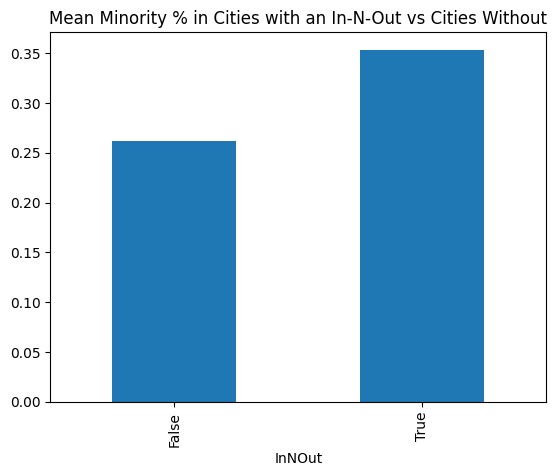

In [7]:
west.groupby(['InNOut'])['Minority Percentage'].mean().plot.bar(title="Mean Minority % in Cities with an In-N-Out vs Cities Without")

On average, cities with an In-N-Out have a higher percent of minorities as part of their population. We should keep this demographic in mind as we move forward and make decisions on which cities In-N-Out can expand into on the East coast.

**3. Machine Learning**

In this final section, we explored multiple machine learning methods and trained 70% of our cleaned data in order to test the remaining 30%. To do so, we first created three different models: Random Forest Classifier, Logistics Regression, and Ridge Classifier. After creating our models, we made confusion matrices for each one to discover which model is the best one to use to predict our test variable.

In [8]:
#creating training and testing data
training = west[:196]
testing = west[196:]

#preprocessor
x_train = training[['Median Age', 'Male Population', 'Female Population',
            'Total Population', 'Number of Veterans', 'Foreign-born',
            'Average Household Size', 'White Percentage', 'Minority Percentage']]
y_train = training['InNOut']

x_test = testing[['Median Age', 'Male Population', 'Female Population',
            'Total Population', 'Number of Veterans', 'Foreign-born',
            'Average Household Size', 'White Percentage', 'Minority Percentage']]
y_test = testing['InNOut']

#pipeline
pipeline1 = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=10))

#train
pipeline1.fit(x_train, y_train)
y_train_predict = pipeline1.predict(x_train)

#test
scores = cross_val_score(
    pipeline1,
    x_train,
    y_train,
    scoring='f1_macro',
    cv=10
)
scores.mean()

0.4805155016552075

**MODEL 1** : Random Forest Classifier


In [9]:
#trying different classifiers
def models(x):
  pipeline1 = make_pipeline(
      StandardScaler(),
      x,
  )
  scores = cross_val_score(
      pipeline1,
      x_train,
      y_train,
      cv=10,
      scoring='f1_macro')
  print(x, scores.mean())
models(DecisionTreeClassifier())
models(GaussianProcessClassifier())
models(GaussianNB()) #high result **
models(RandomForestClassifier()) #highest result
models(RidgeClassifier()) #high result
models(SGDClassifier()) #high result **
models(LogisticRegression()) #high result
models(KNeighborsClassifier())


DecisionTreeClassifier() 0.5318700181703518
GaussianProcessClassifier() 0.5539685192258722
GaussianNB() 0.5874767115220152
RandomForestClassifier() 0.6229641424692708
RidgeClassifier() 0.574763655462185
SGDClassifier() 0.5809818563789152
LogisticRegression() 0.5787219887955182
KNeighborsClassifier() 0.5230643723765167


In [10]:
#hyper-tuning random forest classifier: n_estimators
def n_estimators(x):
  pipeline1 = make_pipeline(
      StandardScaler(),
      RandomForestClassifier(n_estimators = x),
  )
  scores = cross_val_score(
      pipeline1,
      x_train,
      y_train,
      cv=10,
      scoring='f1_macro')
  return scores.mean()

f1scores = pd.Series([])
for x in range(1, 101):
  f1score = n_estimators(x)
  f1scores[x] = f1score
print(f1scores.sort_values(ascending=False))

52    0.630019
17    0.624932
53    0.623291
86    0.616243
36    0.614429
        ...   
20    0.554837
4     0.546655
2     0.546251
3     0.544511
5     0.540748
Length: 100, dtype: float64


In [11]:
#trying different combinations of features
from itertools import combinations
potentialFeatures = ['Median Age', 'Male Population', 'Female Population',
            'Total Population', 'Number of Veterans', 'Foreign-born',
            'Average Household Size', 'White Percentage', 'Minority Percentage']
combination = []
for feat in combinations(potentialFeatures, 8):
  print(feat)
  list(feat)

pipeline = make_pipeline(
      StandardScaler(),
      RandomForestClassifier(n_estimators = 43),
  )
f1 = {}
y_train = training['InNOut']
for size in range(1, len(potentialFeatures) +1):
  for feat in combinations(potentialFeatures, size):
    scores = cross_val_score(
      pipeline,
      x_train,
      y_train,
      cv=10,
      scoring='f1_macro')
    f1[str(list(feat))] = scores.mean()
sorted = pd.Series(f1).sort_values(ascending=False)
sorted

('Median Age', 'Male Population', 'Female Population', 'Total Population', 'Number of Veterans', 'Foreign-born', 'Average Household Size', 'White Percentage')
('Median Age', 'Male Population', 'Female Population', 'Total Population', 'Number of Veterans', 'Foreign-born', 'Average Household Size', 'Minority Percentage')
('Median Age', 'Male Population', 'Female Population', 'Total Population', 'Number of Veterans', 'Foreign-born', 'White Percentage', 'Minority Percentage')
('Median Age', 'Male Population', 'Female Population', 'Total Population', 'Number of Veterans', 'Average Household Size', 'White Percentage', 'Minority Percentage')
('Median Age', 'Male Population', 'Female Population', 'Total Population', 'Foreign-born', 'Average Household Size', 'White Percentage', 'Minority Percentage')
('Median Age', 'Male Population', 'Female Population', 'Number of Veterans', 'Foreign-born', 'Average Household Size', 'White Percentage', 'Minority Percentage')
('Median Age', 'Male Population', '

['Number of Veterans', 'Average Household Size', 'Minority Percentage']                                                                                                                  0.644419
['Male Population', 'Foreign-born']                                                                                                                                                      0.636091
['Median Age', 'Male Population', 'Number of Veterans', 'Average Household Size']                                                                                                        0.635223
['Median Age', 'Male Population', 'Female Population', 'Total Population', 'Number of Veterans', 'Foreign-born', 'Average Household Size', 'White Percentage', 'Minority Percentage']    0.630983
['Median Age', 'Total Population', 'Average Household Size', 'Minority Percentage']                                                                                                      0.628526
                              

In [12]:
#testing cv=10 vs cv=5
x_train1 = training[['Median Age', 'Male Population', 'Female Population', 'Average Household Size', 'Minority Percentage'] ]
y_train = training['InNOut']
eastModel1 = east[['Median Age', 'Male Population', 'Female Population', 'Average Household Size', 'Minority Percentage'] ].dropna()
pipeline1 = make_pipeline(
      StandardScaler(),
      RandomForestClassifier(n_estimators = 43),
      )
scores = cross_val_score(
      pipeline1,
      x_train1,
      y_train,
      cv=10,
      scoring='f1_macro')

scores1 = cross_val_score(
      pipeline,
      x_train1,
      y_train,
      cv=5,
      scoring='f1_macro')
print(scores.mean(), scores1.mean())

0.5508831977527587 0.5842034343074748


In [13]:
#Final Model 1
x_train1 = training[['Median Age', 'Male Population', 'Female Population', 'Average Household Size', 'Minority Percentage'] ]
y_train = training['InNOut']
x_test = testing[['Median Age', 'Male Population', 'Female Population', 'Average Household Size', 'Minority Percentage']]

eastModel1 = east[['Median Age', 'Male Population', 'Female Population', 'Average Household Size', 'Minority Percentage'] ].dropna()
pipeline1 = make_pipeline(
      StandardScaler(),
      RandomForestClassifier(n_estimators = 43),
      )
scores1 = cross_val_score(
      pipeline1,
      x_train1,
      y_train,
      cv=5,
      scoring='f1_macro')
print(scores1.mean())

0.5901150898016959


In [14]:
#confusion matrix

pipeline1.fit(x_train1, y_train)
y_predict = pipeline1.predict(x_test)

pd.DataFrame(
   confusion_matrix(y_test, y_predict),
   index=pipeline1.classes_,
   columns=pipeline1.classes_)


,False,True
False,58,4
True,18,3


**Model 1 Analysis:**

Model 1 gives an f1_macro score of .6495. This means this model predicts locations accurately 64.95% of the time. Model 1 uses the following features: median age, male population, female population, and white percentage. It performs very poorly when predicting True, and fairly well when predicting False.

In [24]:
#Predicting with Model 1
x_train1 = training[['Median Age', 'Male Population', 'Female Population', 'White Percentage']]
y_train = training['InNOut']
eastModel1 = east[['Median Age', 'Male Population', 'Female Population', 'White Percentage']] #159
pipeline1 = make_pipeline(
      StandardScaler(),
      RandomForestClassifier(n_estimators = 43),
      )

pipeline1.fit(x_train1, y_train)
y_predict = pipeline1.predict(eastModel1) #159
east['Predictions'] = y_predict
east[east['Predictions']==True]

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,White Percentage,Minority Percentage,InNOut,Predictions
0,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,0.271013,0.728987,False,True
52,Richmond,Virginia,33.6,104793.0,115496.0,220289,12538.0,15741.0,2.29,VA,0.474686,0.525314,False,True
133,Charleston,South Carolina,35.0,63956.0,71568.0,135524,9368.0,5767.0,2.40,SC,0.767510,0.232490,False,True
157,Fayetteville,North Carolina,30.7,101051.0,100914.0,201965,28089.0,12863.0,2.50,NC,0.505409,0.494591,False,True
161,Charlotte,North Carolina,34.3,396646.0,430475.0,827121,36046.0,128897.0,2.52,NC,0.540181,0.459819,False,True
465,Jersey City,New Jersey,34.3,131765.0,132512.0,264277,4374.0,109186.0,2.57,NJ,0.375742,0.624258,False,True
607,Boynton Beach,Florida,45.8,33701.0,40271.0,73972,4727.0,15431.0,2.45,FL,0.671930,0.328070,False,True
733,Jacksonville,Florida,35.7,419203.0,448828.0,868031,75432.0,85650.0,2.62,FL,0.626224,0.373776,False,True
870,Augusta-Richmond County consolidated government,Georgia,33.7,94662.0,101917.0,196579,19085.0,7915.0,2.67,GA,0.396482,0.603518,False,True
881,New York,New York,36.0,4081698.0,4468707.0,8550405,156961.0,3212500.0,2.68,NY,0.448602,0.551398,False,True


Next, we used the Whataburger dataset to test out how well our chosen model predicts the correct location.

In [25]:
cities = pd.Series([])
whata_locs = pd.Series([])

for x, y in whataburger['city'].items():
  whata_locs[x] = y

for x, y in df['City'].items():
  cities[x] = y

matches = cities.isin(whata_locs)
df['in_df'] = matches

westWhata = df[(df['State Code'] == 'CA') | (df['State Code'] == 'TX') | (df['State Code'] == 'OR')
 |(df['State Code'] == 'WA') |(df['State Code'] == 'CO') |(df['State Code'] == 'NV') |(df['State Code'] == 'ID') |
  (df['State Code'] == 'MT') |(df['State Code'] == 'AZ') |(df['State Code'] == 'NM') |(df['State Code'] == 'UT') |
  (df['State Code'] == 'WY')]

eastWhata = (df[((df['State Code'] == 'ME') | (df['State Code'] == 'VA') | (df['State Code'] == 'NC')
 |(df['State Code'] == 'SC') |(df['State Code'] == 'GA') |(df['State Code'] == 'FL') |(df['State Code'] == 'PA') |
  (df['State Code'] == 'NY') |(df['State Code'] == 'DE') |(df['State Code'] == 'RI') |(df['State Code'] == 'CT') |
  (df['State Code'] == 'VT') |(df['State Code'] == 'MA') |(df['State Code'] == 'NH') |(df['State Code'] == 'MD')|
  (df['State Code'] == 'NJ')) & (df['City'] != 'Union City') &(df['City'] != 'Reading')]).dropna()

In [26]:
x_trainV = westWhata[['Median Age', 'Male Population', 'Female Population', 'White Percentage']]
y_trainV = westWhata['in_df']

eastPred = eastWhata[['Median Age', 'Male Population', 'Female Population', 'White Percentage']]

pipeline1.fit(x_trainV, y_trainV)
y_predict = pipeline1.predict(eastPred)
eastWhata['Predictions'] = y_predict
predictions = eastWhata[eastWhata['Predictions']==True]
predictions

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,White Percentage,Minority Percentage,InNOut,in_df,Predictions
133,Charleston,South Carolina,35.0,63956.0,71568.0,135524,9368.0,5767.0,2.40,SC,0.767510,0.232490,False,False,True
152,Chesapeake,Virginia,36.7,114964.0,120465.0,235429,29772.0,13966.0,2.73,VA,0.638893,0.361107,False,False,True
159,Athens-Clarke County unified government,Georgia,26.5,57415.0,65148.0,122563,3953.0,12868.0,2.44,GA,0.652163,0.347837,False,False,True
568,Miami,Florida,40.4,215840.0,225149.0,440989,7233.0,260789.0,2.50,FL,0.766985,0.233015,False,False,True
739,Hialeah,Florida,43.0,111530.0,125552.0,237082,1844.0,170148.0,3.31,FL,0.927911,0.072089,False,False,True
853,Homestead,Florida,31.4,31401.0,35099.0,66500,2287.0,24408.0,3.48,FL,0.734135,0.265865,False,False,True
1091,Saint Petersburg,Florida,41.8,123524.0,133564.0,257088,20247.0,28567.0,2.42,FL,0.696730,0.303270,False,False,True
1262,Alexandria,Virginia,36.6,74989.0,78522.0,153511,10635.0,44030.0,2.20,VA,0.691905,0.308095,False,False,True
1436,Wilmington,North Carolina,35.5,52346.0,63601.0,115947,5908.0,7401.0,2.24,NC,0.769921,0.230079,False,False,True
2300,Orlando,Florida,33.1,130940.0,139977.0,270917,12782.0,50558.0,2.42,FL,0.661166,0.338834,False,False,True


In [27]:
correctPred = whataburger[(whataburger['city'] == 'Charleston')|(whataburger['city'] == 'Miami')|(whataburger['city'] == 'Hialeah')|
                   (whataburger['city'] == 'Homestead')|(whataburger['city'] == 'Saint Petersburg')|(whataburger['city'] == 'Alexandria')|
                   (whataburger['city'] == 'Wilmington')|(whataburger['city'] == 'Columbia')|(whataburger['city'] == 'Orlando')|
                   (whataburger['city'] == 'Gainsville')|(whataburger['city'] == 'Stamford')|(whataburger['city'] == 'Cambridge')|
                   (whataburger['city'] == 'Raleigh')]
correctPred

,city,state


**Verification Analysis**

This verification used a dataset on Whataburger locations. We split the data into Whataburger locations in western states and Whataburger locations in eastern states. We trained Model 1 on the western locations and predicted on the eastern locations to test if cities that have Whataburger locations were correctly identified. With the  confusion matrix results for this model in mind, it is not surprising that the model did not predict most cities that currently have a Whataburger location.

**Reflection**

Based on the results from testing out our Whataburger data, our model was not very accurate. If we were to do this project again, we would need to collect more data in order to create a better predictive model. Our training data did not have enough rows where an In-N-Out existed, to make the code learn well enough, so the model was not the best at predicting the values to be True.  